In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import trapezoid

def wrap_angle(a):
    """Wrap angle to [-pi, pi]."""
    return (a + np.pi) % (2*np.pi) - np.pi

def rotmat_body_to_inertial(phi, theta, psi):
    """
    R_IB: body -> inertial, Z-Y-X (yaw-pitch-roll).
    Inertial: Z up
    Body: z_B up along thrust
    """
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    # Rz(psi) * Ry(theta) * Rx(phi)
    R = np.array([
        [cpsi*cth,  cpsi*sth*sphi - spsi*cphi,  cpsi*sth*cphi + spsi*sphi],
        [spsi*cth,  spsi*sth*sphi + cpsi*cphi,  spsi*sth*cphi - cpsi*sphi],
        [   -sth,                  cth*sphi,                  cth*cphi]
    ])
    return R

def euler_rates(phi, theta, psi, p, q, r):
    """
    Euler angle rates from body rates (standard quadrotor convention).
    """
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)

    tan_th = np.tan(theta)
    sec_th = 1.0 / cth

    phi_dot   = p + q*sphi*tan_th + r*cphi*tan_th
    theta_dot =     q*cphi        - r*sphi
    psi_dot   =     q*sphi*sec_th + r*cphi*sec_th

    return np.array([phi_dot, theta_dot, psi_dot])

In [10]:
class QuadParams:
    def __init__(self):
        # physical parameters
        # Frame Parameters
        F_mass = 280.5*(10**-3) #kg
        A_length = 209.304*(10**-3) #m

        #Motor Parameters
        M_mass = 34*(10**-3) #kg
        k_f = ...
        k_m = ...
        kt = ...

        #Rotor Parameters
        rot_mass = 4.2*(10**-3) #kg

        #Battery Parameters
        B_mass  = 72*(10**-3) #kg
        curr_cap = 720 #mAh

        self.m  = F_mass + M_mass + rot_mass + B_mass       # kg
        self.g  = 9.81     # m/s^2
        self.l  = A_length    # arm length [m]
        self.cc = curr_cap
        # thrust / drag coefficients: T = k_f w^2, Q = k_m w^2
        self.k_f = 1.8e-5
        self.k_m = 2.5e-6

        # motor torque constant
        self.k_t = 0.04   # [N·m / A]

        # inertia (diagonal)
        self.Ix = 0.02
        self.Iy = 0.02
        self.Iz = 0.04

        # max rotor speed
        self.w_max = 1500.0  # rad/s

        # allocation matrix [U1,U2,U3,U4]^T = B [w1^2..w4^2]^T
        # rotor numbering: 1 front, 2 right, 3 back, 4 left
        l  = self.l
        kf = self.k_f
        km = self.k_m

        # U1 = total thrust
        # U2 = roll torque tau_phi
        # U3 = pitch torque tau_theta
        # U4 = yaw torque tau_psi
        self.B = np.array([
            [kf,      kf,      kf,      kf     ],
            [0.0,   l*kf,    0.0,   -l*kf     ],
            [-l*kf, 0.0,   l*kf,    0.0       ],
            [km,   -km,     km,    -km       ]
        ])
        self.B_inv = np.linalg.inv(self.B)


def quad_dynamics(t, x, w, params: QuadParams):
    """
    State x = [X,Y,Z, Vx,Vy,Vz, phi,theta,psi, p,q,r]
    w: rotor speeds [w1, w2, w3, w4]
    """
    m, g = params.m, params.g
    Ix, Iy, Iz = params.Ix, params.Iy, params.Iz

    # unpack state
    X, Y, Z        = x[0:3]
    Vx, Vy, Vz     = x[3:6]
    phi, th, psi   = x[6:9]
    p, q, r        = x[9:12]

    # rotor speeds -> thrust & torques
    w2 = w**2
    U  = params.B @ w2        # [U1, U2, U3, U4]
    U1, tau_phi, tau_theta, tau_psi = U

    # translational dynamics
    R_IB   = rotmat_body_to_inertial(phi, th, psi)
    F_T_I  = R_IB @ np.array([0.0, 0.0, U1])  # thrust along +z_B
    F_g    = np.array([0.0, 0.0, -m*g])      # gravity (Z up)
    F_tot  = F_g + F_T_I

    Xdot, Ydot, Zdot = Vx, Vy, Vz
    Vxdot, Vydot, Vzdot = F_tot / m

    # rotational dynamics: your component form
    pdot = (tau_phi   / Ix) - ((Iy - Iz)/Ix)*q*r
    qdot = (tau_theta / Iy) - ((Iz - Ix)/Iy)*p*r
    rdot = (tau_psi   / Iz) - ((Ix - Iy)/Iz)*p*q

    # Euler angle kinematics
    phi_dot, th_dot, psi_dot = euler_rates(phi, th, psi, p, q, r)

    dx = np.zeros_like(x)
    dx[0:3]   = [Xdot, Ydot, Zdot]
    dx[3:6]   = [Vxdot, Vydot, Vzdot]
    dx[6:9]   = [phi_dot, th_dot, psi_dot]
    dx[9:12]  = [pdot, qdot, rdot]
    return dx


In [11]:
class QuadController:
    def __init__(self, params: QuadParams):
        self.params = params

        # Position PD (in inertial, Z up)
        self.Kp_pos = np.array([4.0, 4.0, 5.0])
        self.Kd_pos = np.array([2.0, 2.0, 3.0])

        # Attitude PD (phi, theta, psi)
        self.Kp_att = np.array([12.0, 12.0, 4.0])
        self.Kd_att = np.array([4.0,  4.0,  2.0])

    def compute_control(self, t, x, r_des, v_des, yaw_des, a_ff=np.zeros(3)):
        m, g = self.params.m, self.params.g

        pos  = x[0:3]
        vel  = x[3:6]
        phi, th, psi = x[6:9]
        p, q, r      = x[9:12]

        # outer loop: position PD 
        e_r = r_des - pos
        e_v = v_des - vel
        a_des_I = self.Kp_pos * e_r + self.Kd_pos * e_v + a_ff

        # altitude -> total thrust 
        a_z_des = a_des_I[2]
        U1_des  = m * (g + a_z_des)
        U1_des  = max(0.1, U1_des)

        # horizontal accel -> desired roll/pitch 
        a_xy_I = a_des_I[0:2]
        cpsi, spsi = np.cos(psi), np.sin(psi)

        axB =  cpsi*a_xy_I[0] + spsi*a_xy_I[1]
        ayB = -spsi*a_xy_I[0] + cpsi*a_xy_I[1]

        theta_des =  axB / g    # pitch
        phi_des   = -ayB / g    # roll

        # yaw control 
        yaw_err = wrap_angle(yaw_des - psi)

        # inner loop: attitude PD -> torques 
        e_att   = np.array([phi_des - phi, theta_des - th, yaw_err])
        e_omega = -np.array([p, q, r])

        tau = self.Kp_att * e_att + self.Kd_att * e_omega
        tau_phi, tau_theta, tau_psi = tau

        U_vec = np.array([U1_des, tau_phi, tau_theta, tau_psi])
        w2 = self.params.B_inv @ U_vec
        w2 = np.clip(w2, 0.0, self.params.w_max**2)
        w  = np.sqrt(w2)
        return w


In [12]:
def rk4_step(f, t, x, dt, *args):
    k1 = f(t,         x,            *args)
    k2 = f(t + dt/2,  x + dt/2*k1,  *args)
    k3 = f(t + dt/2,  x + dt/2*k2,  *args)
    k4 = f(t + dt,    x + dt*k3,    *args)
    return x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)


Hover: mean Z over last 120 s = 0.9998679166864206


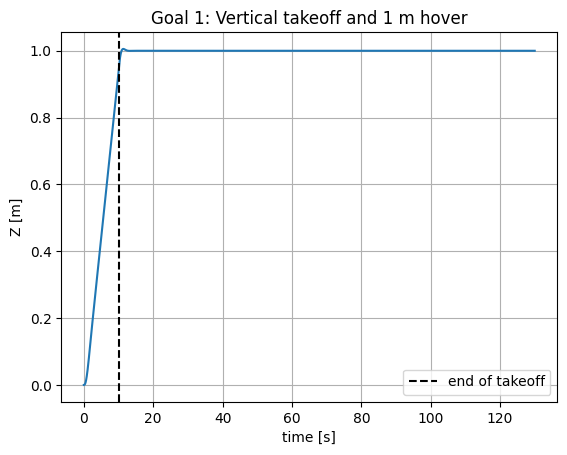

In [13]:
def simulate_hover():
    params = QuadParams()
    ctrl   = QuadController(params)

    T_final = 130.0      # 10 s takeoff + 120 s hover
    dt      = 0.005
    N       = int(T_final / dt)

    # initial state: on ground at origin, level, no rates
    x = np.zeros(12)     # [X,Y,Z,Vx,Vy,Vz,phi,th,psi,p,q,r]

    t_log = []
    z_log = []

    for k in range(N):
        t = k * dt

        # reference profile for goal 1 
        if t < 10.0:
            # vertical takeoff: ramp Z_des from 0 -> 1 m over 10 s
            z_des = 0.1 * t
        else:
            # hover at 1 m
            z_des = 1.0

        r_des  = np.array([0.0, 0.0, z_des])
        v_des  = np.zeros(3)    # we let the PD do the climbing
        yaw_des = 0.0

        w = ctrl.compute_control(t, x, r_des, v_des, yaw_des)
        x = rk4_step(quad_dynamics, t, x, dt, w, params)

        t_log.append(t)
        z_log.append(x[2])

    z_log = np.array(z_log)
    print("Hover: mean Z over last 120 s =", z_log[int(10.0/dt):].mean())

    plt.figure()
    plt.plot(t_log, z_log)
    plt.axvline(10.0, color='k', linestyle='--', label='end of takeoff')
    plt.xlabel("time [s]")
    plt.ylabel("Z [m]")
    plt.title("Goal 1: Vertical takeoff and 1 m hover")
    plt.legend()
    plt.grid(True)
    plt.show()

simulate_hover()


Goal 2 - max |body torque| [N·m] (phi, theta, psi): [0.1743531  0.1529052  3.40775702]
Goal 2 - max motor current [A] per rotor: [43.86526353  3.57460814 41.32866208  3.56351647]


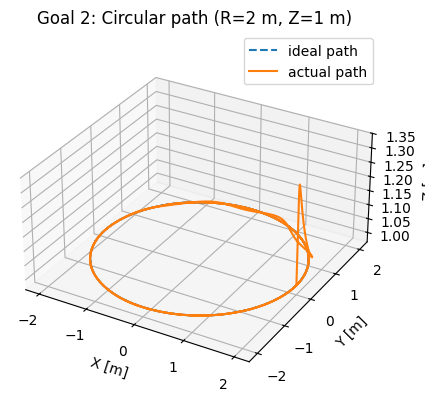

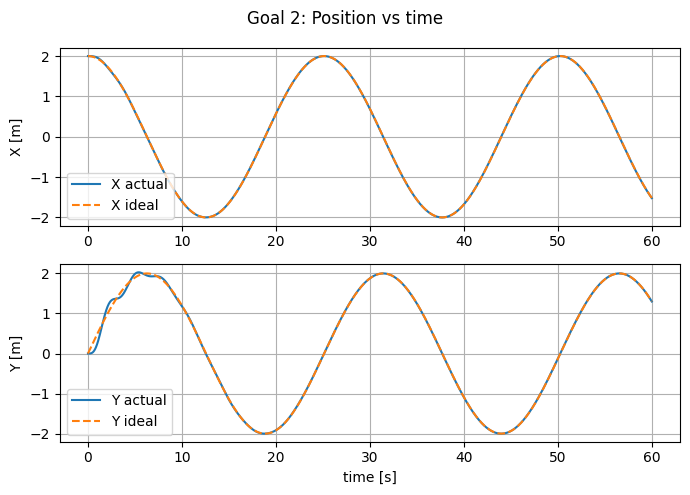

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
def simulate_circle():
    params = QuadParams()
    ctrl   = QuadController(params)

    R = 2.0
    v_t = 0.5
    omega = v_t / R

    T_final = 60.0
    dt      = 0.005
    N       = int(T_final/dt)

    x = np.zeros(12)
    x[0] = R       # start on the circle at (R,0,1)
    x[2] = 1.0

    t_log      = []
    pos_log    = []
    ref_log    = []   # ideal path
    tau_log    = []   # body torques [tau_phi, tau_theta, tau_psi]
    curr_log   = []   # motor currents [I1..I4]

    for k in range(N):
        t = k * dt

        #  ideal reference circle 
        theta = omega * t
        Xd = R*np.cos(theta)
        Yd = R*np.sin(theta)
        Zd = 1.0

        Vx_d = -R*omega*np.sin(theta)
        Vy_d =  R*omega*np.cos(theta)
        Vz_d = 0.0

        r_des = np.array([Xd, Yd, Zd])
        v_des = np.array([Vx_d, Vy_d, Vz_d])

        # centripetal accel feedforward
        ax_ff = -R*omega**2*np.cos(theta)
        ay_ff = -R*omega**2*np.sin(theta)
        az_ff = 0.0
        a_ff  = np.array([ax_ff, ay_ff, az_ff])

        yaw_des = np.arctan2(Vy_d, Vx_d + 1e-9)

        #  control 
        w = ctrl.compute_control(t, x, r_des, v_des, yaw_des, a_ff=a_ff)

        # log torques from mixer
        w2 = w**2
        U  = params.B @ w2                 # [U1, tau_phi, tau_theta, tau_psi]
        _, tau_phi, tau_theta, tau_psi = U
        tau_log.append([tau_phi, tau_theta, tau_psi])

        # per-motor reaction torque + current
        Q = params.k_m * w2                # [Q1..Q4]
        I = Q / params.k_t                 # [I1..I4]
        curr_log.append(I)

        # integrate dynamics
        x = rk4_step(quad_dynamics, t, x, dt, w, params)

        t_log.append(t)
        pos_log.append(x[0:3].copy())
        ref_log.append([Xd, Yd, Zd])

    pos_log  = np.array(pos_log)
    ref_log  = np.array(ref_log)
    tau_log  = np.array(tau_log)
    curr_log = np.array(curr_log)

    # print torque and current info
    print("Goal 2 - max |body torque| [N·m] (phi, theta, psi):",
          np.max(np.abs(tau_log), axis=0))
    print("Goal 2 - max motor current [A] per rotor:",
          np.max(curr_log, axis=0))

    #  3D path (actual vs ideal) 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(ref_log[:,0], ref_log[:,1], ref_log[:,2],
            '--', label='ideal path')
    ax.plot(pos_log[:,0], pos_log[:,1], pos_log[:,2],
            label='actual path')
    
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    ax.set_title("Goal 2: Circular path (R=2 m, Z=1 m)")
    ax.legend()
    ax.set_box_aspect([1,1,0.5])
    plt.show()

    #  X(t) and Y(t) vs time 
    plt.figure(figsize=(7,5))
    plt.subplot(2,1,1)
    plt.plot(t_log, pos_log[:,0], label='X actual')
    plt.plot(t_log, ref_log[:,0], '--', label='X ideal')
    plt.ylabel("X [m]")
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t_log, pos_log[:,1], label='Y actual')
    plt.plot(t_log, ref_log[:,1], '--', label='Y ideal')
    plt.xlabel("time [s]")
    plt.ylabel("Y [m]")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Goal 2: Position vs time")
    plt.tight_layout()
    plt.show()
    
    curr_lis = curr_log.tolist()
    tlis = t_log
    cdraw = trapezoid(curr_lis, tlis)
    

simulate_circle()


Goal 3 - final position [X,Y,Z] = [ 5.     5.    -0.006]
Goal 3 - max |body torque| [N·m] (phi, theta, psi): [0.24219787 2.07248402 0.24470182]
Goal 3 - max motor current [A] per rotor: [31.61971396 13.35997206 31.98277814 14.8102461 ]
Goal 3 - max |Vz| during landing phase: 0.01500876817247105


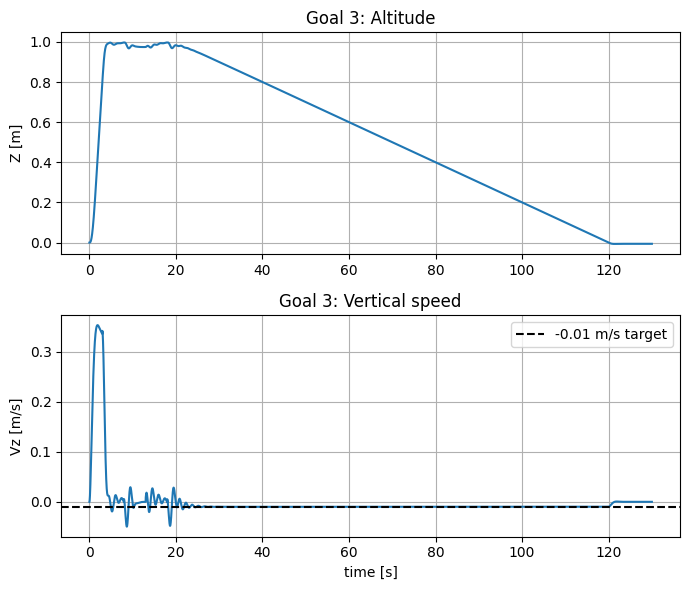

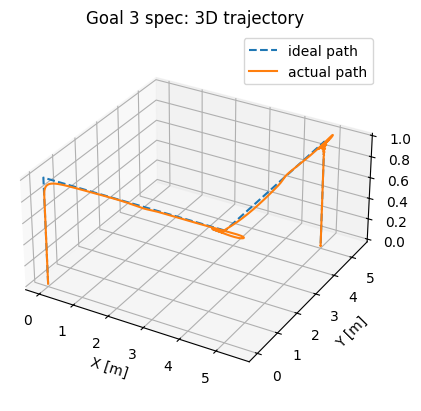

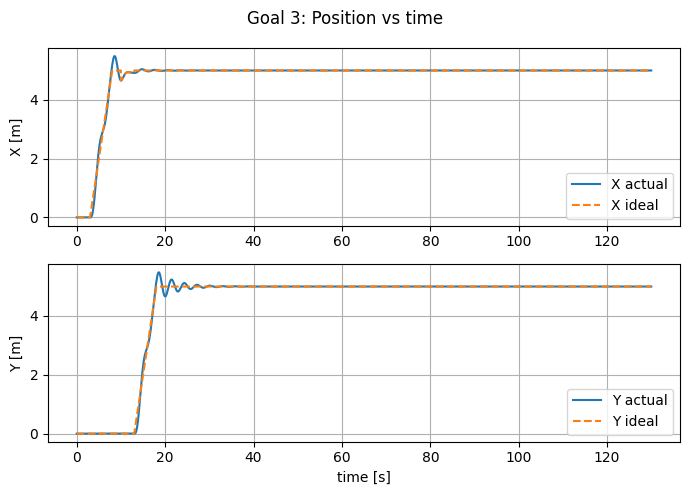

In [ ]:
def simulate_mission():

    params = QuadParams()
    ctrl   = QuadController(params)

    dt = 0.005

    #  timing of phases 
    T_asc        = 3.0
    T_leg        = 5.0     # 5 m at 1 m/s
    T_hover      = 2.0
    T_yaw        = 3.0
    T_leg2       = 5.0
    T_hover2     = 2.0
    T_land_len   = 110.0   # ~1 m at 0.01 m/s + margin

    t_leg1_start   = T_asc
    t_leg1_end     = t_leg1_start   + T_leg
    t_hover1_start = t_leg1_end
    t_hover1_end   = t_hover1_start + T_hover
    t_yaw_start    = t_hover1_end
    t_yaw_end      = t_yaw_start    + T_yaw
    t_leg2_start   = t_yaw_end
    t_leg2_end     = t_leg2_start   + T_leg2
    t_hover2_start = t_leg2_end
    t_hover2_end   = t_hover2_start + T_hover2
    t_land_start   = t_hover2_end
    T_final        = t_land_start   + T_land_len

    N = int(T_final / dt)

    x = np.zeros(12)   # start at origin on ground

    t_log    = []
    pos_log  = []
    ref_log  = []      # ideal path
    vz_log   = []
    tau_log  = []      # body torques
    curr_log = []      # motor currents

    for k in range(N):
        t = k * dt

        #  Phase 1: ascent 
        if t < T_asc:
            z_des = (t / T_asc) * 1.0
            r_des = np.array([0.0, 0.0, z_des])
            v_des = np.zeros(3)
            yaw_des = 0.0

        #  Phase 2: leg 1 along +X 
        elif t < t_leg1_end:
            tau = t - t_leg1_start
            x_des = min(5.0, 1.0 * tau)
            r_des = np.array([x_des, 0.0, 1.0])
            if x_des < 5.0:
                v_des = np.array([1.0, 0.0, 0.0])
            else:
                v_des = np.zeros(3)
            yaw_des = 0.0

        #  Phase 3: hover 1 
        elif t < t_hover1_end:
            r_des = np.array([5.0, 0.0, 1.0])
            v_des = np.zeros(3)
            yaw_des = 0.0

        #  Phase 4: yaw 90 deg left 
        elif t < t_yaw_end:
            r_des = x[0:3].copy()
            v_des = np.zeros(3)
            tau = t - t_yaw_start
            yaw_des = (tau / T_yaw) * (np.pi/2)

        #  Phase 5: leg 2 along +Y 
        elif t < t_leg2_end:
            tau = t - t_leg2_start
            y_des = min(5.0, 1.0 * tau)
            r_des = np.array([5.0, y_des, 1.0])
            if y_des < 5.0:
                v_des = np.array([0.0, 1.0, 0.0])
            else:
                v_des = np.zeros(3)
            yaw_des = np.pi/2

        #  Phase 6: hover 2 
        elif t < t_hover2_end:
            r_des = np.array([5.0, 5.0, 1.0])
            v_des = np.zeros(3)
            yaw_des = np.pi/2

        #  Phase 7: vertical landing 
        else:
            v_landing = -0.01     # -1 cm/s
            tau = t - t_land_start
            z_des = max(0.0, 1.0 + v_landing * tau)
            r_des = np.array([5.0, 5.0, z_des])
            v_des = np.array([0.0, 0.0, v_landing])
            yaw_des = np.pi/2

        # log ideal reference before control
        ref_log.append(r_des.copy())

        # control
        w = ctrl.compute_control(t, x, r_des, v_des, yaw_des)

        # torques from mixer
        w2 = w**2
        U  = params.B @ w2
        _, tau_phi, tau_theta, tau_psi = U
        tau_log.append([tau_phi, tau_theta, tau_psi])

        # motor currents
        Q = params.k_m * w2
        I = Q / params.k_t
        curr_log.append(I)

        # integrate dynamics
        x = rk4_step(quad_dynamics, t, x, dt, w, params)

        t_log.append(t)
        pos_log.append(x[0:3].copy())
        vz_log.append(x[5])

    pos_log  = np.array(pos_log)
    ref_log  = np.array(ref_log)
    vz_log   = np.array(vz_log)
    tau_log  = np.array(tau_log)
    curr_log = np.array(curr_log)

    print("Goal 3 - final position [X,Y,Z] =", pos_log[-1])
    print("Goal 3 - max |body torque| [N·m] (phi, theta, psi):",
          np.max(np.abs(tau_log), axis=0))
    print("Goal 3 - max motor current [A] per rotor:",
          np.max(curr_log, axis=0))
    print("Goal 3 - max |Vz| during landing phase:",
          np.max(np.abs(vz_log[int(t_land_start/dt):])))

    #  altitude & vertical speed 
    plt.figure(figsize=(7,6))
    plt.subplot(2,1,1)
    plt.plot(t_log, pos_log[:,2])
    plt.ylabel("Z [m]")
    plt.title("Goal 3: Altitude")
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t_log, vz_log)
    plt.axhline(-0.01, linestyle='--', color='k', label='-0.01 m/s target')
    plt.xlabel("time [s]")
    plt.ylabel("Vz [m/s]")
    plt.title("Goal 3: Vertical speed")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  3D actual vs ideal path 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(ref_log[:,0], ref_log[:,1], ref_log[:,2],
            '--', label='ideal path')
    ax.plot(pos_log[:,0], pos_log[:,1], pos_log[:,2],
            label='actual path')
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    ax.set_title("Goal 3 spec: 3D trajectory")
    ax.legend()
    ax.set_box_aspect([1,1,0.5])
    plt.show()

    #  X(t), Y(t) vs time 
    plt.figure(figsize=(7,5))
    plt.subplot(2,1,1)
    plt.plot(t_log, pos_log[:,0], label='X actual')
    plt.plot(t_log, ref_log[:,0], '--', label='X ideal')
    plt.ylabel("X [m]")
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t_log, pos_log[:,1], label='Y actual')
    plt.plot(t_log, ref_log[:,1], '--', label='Y ideal')
    plt.xlabel("time [s]")
    plt.ylabel("Y [m]")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Goal 3: Position vs time")
    plt.tight_layout()
    plt.show()

simulate_mission()
